Recherche des meilleurs hyperparamètres...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Meilleurs hyperparamètres trouvés :
{'colsample_bytree': np.float64(0.9659851446851979), 'learning_rate': np.float64(0.015523354374740941), 'max_depth': 5, 'n_estimators': 521, 'reg_alpha': np.float64(0.43847412301808697), 'reg_lambda': np.float64(1.8440522705903988), 'subsample': np.float64(0.7984458002424195)}

Performance du Modèle Optimisé:
✅ RMSE: 2.070 W
✅ MAE : 1.628 W
✅ R²  : 0.969


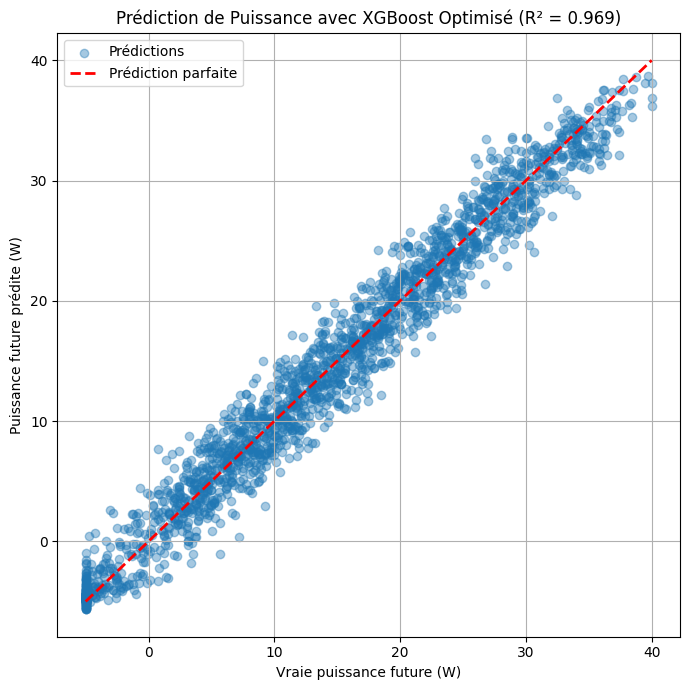


Modèle optimisé sauvegardé : xgboost_power_predictor_optimized.pkl


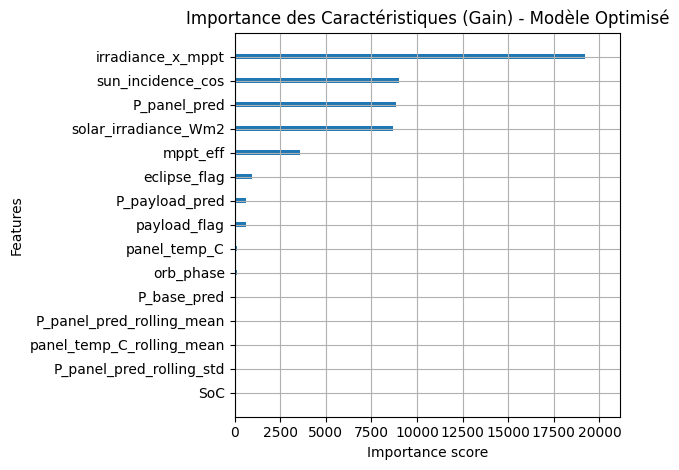

Sauvegarde des résultats pour comparaison...
✅ Fichier de comparaison 'prediction_comparison.csv' sauvegardé.
Ce fichier contient les valeurs réelles et prédites du jeu de test.


In [ ]:

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib
from scipy.stats import uniform, randint

# 1. Charger le dataset amélioré
df = pd.read_csv("sim_power_data_enhanced.csv")
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# 2. Définir les features et la cible
features = [
    'orb_phase', 'eclipse_flag', 'sun_incidence_cos', 'solar_irradiance_Wm2',
    'panel_temp_C', 'P_panel_pred', 'mppt_eff', 'payload_flag',
    'P_payload_pred', 'P_base_pred', 'SoC',
    'P_panel_pred_rolling_mean', 'P_panel_pred_rolling_std',
    'panel_temp_C_rolling_mean', 'irradiance_x_mppt'
]
target = 'P_future_720s'

X = df[features]
y = df[target]

# 3. Diviser les données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Optimisation des hyperparamètres
param_dist = {
    'n_estimators': randint(200, 600),
    'max_depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_lambda': uniform(0.5, 2.0),
    'reg_alpha': uniform(0, 1.0)
}
xgb_model = xgb.XGBRegressor(
    tree_method="hist", eval_metric="rmse", random_state=42, n_jobs=-1
)
random_search = RandomizedSearchCV(
    estimator=xgb_model, param_distributions=param_dist, n_iter=50,
    scoring='neg_root_mean_squared_error', cv=5, verbose=1, random_state=42, n_jobs=-1
)
print("Recherche des meilleurs hyperparamètres...")
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print(f"\nMeilleurs hyperparamètres trouvés :\n{random_search.best_params_}")

# 5. Évaluer le modèle optimisé
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPerformance du Modèle Optimisé:")
print(f"✅ RMSE: {rmse:.3f} W")
print(f"✅ MAE : {mae:.3f} W")
print(f"✅ R²  : {r2:.3f}")

# 6. Visualiser les résultats
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.4, label="Prédictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Prédiction parfaite")
plt.xlabel("Vraie puissance future (W)")
plt.ylabel("Puissance future prédite (W)")
plt.title(f"Prédiction de Puissance avec XGBoost Optimisé (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Sauvegarder le modèle optimisé
joblib.dump(best_model, "xgboost_power_predictor_optimized.pkl")
print("\nModèle optimisé sauvegardé : xgboost_power_predictor_optimized.pkl")

# 8. Importance des caractéristiques
xgb.plot_importance(best_model, importance_type='gain', show_values=False)
plt.title("Importance des Caractéristiques (Gain) - Modèle Optimisé")
plt.tight_layout()
plt.show()


# Sauvegarder les prédictions vs les vraies valeurs dans un CSV

print("Sauvegarde des résultats pour comparaison...")
comparison_df = pd.DataFrame({
    'True_Future_Power': y_test,
    'Predicted_Future_Power': y_pred
})
comparison_df = comparison_df.round(3)
comparison_df.to_csv("prediction_comparison.csv", index=False)
print("✅ Fichier de comparaison 'prediction_comparison.csv' sauvegardé.")
print("Ce fichier contient les valeurs réelles et prédites du jeu de test.")